# Home Depot Product Search Relevance IRDM Porject

## <font color='green'>Setup 1</font>: Envrionment Setup

In [26]:
from config import *

import time
start_time = time.time()

import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.mpl_style = 'default'

import re
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.stem.snowball import SnowballStemmer
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor,AdaBoostRegressor,RandomForestClassifier,AdaBoostClassifier
from collections import Counter

stemmer = SnowballStemmer('english')

In [28]:
num_test

166693

## <font color='green'>Setup 2</font>: Import Data

In [27]:
df_train_pre = pd.read_csv(PROCESSINGTEXT_DIR + '/df_train_processed-pairwise.csv', encoding="ISO-8859-1")
df_test = pd.read_csv(PROCESSINGTEXT_DIR + '/df_test_processed-pairwise.csv', encoding="ISO-8859-1")
df_attr_bullet = pd.read_csv(PROCESSINGTEXT_DIR + '/df_attribute_bullets_processed.csv')
df_pro_desc = pd.read_csv(PROCESSINGTEXT_DIR + '/df_product_descriptions_processed.csv') 

num_train = df_train_pre.shape[0]
num_test = df_test.shape[0]

df_train = df_train_pre[:int(round(0.8*num_train))]
df_val = df_train_pre[int(round(0.8*num_train)):]

df_train = df_train.sort_values('search_term')
train_group = [value for (key, value) in sorted(Counter(df_train['search_term']).items())]

df_val = df_val.sort_values('search_term')
val_group = [value for (key, value) in sorted(Counter(df_val['search_term']).items())]

df_test = df_test.sort_values('search_term')
test_group = [value for (key, value) in sorted(Counter(df_test['search_term']).items())]

df_all = pd.concat((df_train,df_val,df_test), axis=0, ignore_index=True)
df_all = pd.merge(df_all, df_attr_bullet, how='left', on='product_uid')
df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')

In [29]:
for var in df_all.keys():
    df_all[var]=df_all[var].fillna("")

In [30]:
remove_list=[str(x) for x in list(df_all.columns)]

for x in ['id','product_uid','relevance','is_query_misspelled']:
    remove_list.remove(x)

In [31]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
query_label = label_encoder.fit_transform(df_all['search_term'])

In [32]:
df_all[:50]

,brand,brand_parsed,brands_in_product_title,brands_in_search_term,id,is_query_misspelled,material,material_parsed,materials_in_product_title,materials_in_search_term,product_title,product_title_parsed,product_title_parsed_woBM,product_title_parsed_woBrand,product_title_simpleparsed,product_title_stemmed,product_title_stemmed_woBM,product_title_stemmed_woBrand,product_title_tokens,product_uid,query freq,relevance,search_term,search_term_parsed,search_term_parsed_woBM,search_term_parsed_woBrand,search_term_simpleparsed,search_term_stemmed,search_term_stemmed_woBM,search_term_stemmed_woBrand,search_term_tokens,attribute_bullets,attribute_bullets_parsed,attribute_bullets_parsed_woBrand,brands_in_attribute_bullets,attribute_bullets_parsed_woBM,materials_in_attribute_bullets,attribute_bullets_tokens,attribute_bullets_stemmed,product_description,product_description_parsed,product_description_parsed_woBrand,brands_in_product_description,product_description_parsed_woBM,materials_in_product_description,product_description_stemmed
0,Milwaukee,milwaukee,milwaukee,,104248,1.0,Steel,steel,,,Milwaukee 3/8 in. Ergo Quick-Change Saw Arbor,milwaukee 3/8-in ergo quick change saw arbor,3/8-in ergo quick change saw arbor,3/8-in ergo quick change saw arbor,milwaukee 38 in ergo quick change saw arbor,milwauke 3/8-in ergo quick chang saw arbor,3/8-in ergo quick chang saw arbor,3/8-in ergo quick chang saw arbor,"[(3/8-in, JJ), (ergo, NN), (quick, JJ), (chang...",133315,8,2,$ hole saw,$ hole saw,$ hole saw,$ hole saw,hole saw,$ hole saw,$ hole saw,$ hole saw,"[($, $), (hole, NN), (saw, NN)]",Made from hardened carbon steel and alloy stee...,made from hardened carbon steel and alloy stee...,made from hardened carbon steel and alloy stee...,,made from hardened and for superb durability. ...,carbon steel;steel;alloy,"[(made, VBN), (from, IN), (hardened, VBN), (an...",made harden carbon steel alloy steel superb du...,Make hole saw bit changes quickly and easily w...,make hole saw bit changes quickly and easily w...,make hole saw bit changes quickly and easily w...,milwaukee,make hole saw bit changes quickly and easily w...,carbon steel;steel;alloy,make hole saw bit chang quick easili milwauke ...
1,Ryobi,ryobi,ryobi,,85412,1.0,Steel,steel,,,Ryobi Hole Saw Set (6-Piece),ryobi hole saw set,hole saw set,hole saw set,ryobi hole saw set 6 piece,ryobi hole saw set,hole saw set,hole saw set,"[(hole, NN), (saw, VBD), (set, VBN)]",125403,8,2.33,$ hole saw,$ hole saw,$ hole saw,$ hole saw,hole saw,$ hole saw,$ hole saw,$ hole saw,"[($, $), (hole, NN), (saw, NN)]",For use with wood drilling. Alternate tooth de...,for use with wood drilling. alternate tooth de...,for use with wood drilling. alternate tooth de...,ryobi,for use with drilling. alternate tooth design ...,wood,"[(for, IN), (use, NN), (with, IN), (drilling, ...",use wood drill altern tooth design easier plug...,These carbon steel hole saws from Ryobi are pe...,these carbon steel hole saws from ryobi are pe...,these carbon steel hole saws from are perfect ...,ryobi,these hole saws from are perfect for drilling ...,carbon steel;wood,carbon steel hole saw ryobi perfect drill wood...
2,Bosch,bosch,bosch,,46280,1.0,,,,,Bosch Daredevil Spade Bit Set (10-Pieces),bosch daredevil spade bit set,daredevil spade bit set,daredevil spade bit set,bosch daredevil spade bit set 10 pieces,bosch daredevil spade bit set,daredevil spade bit set,daredevil spade bit set,"[(daredevil, NN), (spade, VBD), (bit, NN), (se...",111472,8,2,$ hole saw,$ hole saw,$ hole saw,$ hole saw,hole saw,$ hole saw,$ hole saw,$ hole saw,"[($, $), (hole, NN), (saw, NN)]",Full-cone threaded tip for fast and effortless...,full cone threaded tip for fast and effortless...,full cone threaded tip for fast and effortless...,,full cone threaded tip for fast and effortless...,,"[(full, JJ), (cone, NN), (threaded, VBD), (tip...",full cone thread tip fast effortless drill spu...,The Bosch Daredevil Spade Bit Set of 10 includ...,the bosch daredevil spade bit set

## <font color='green'>Setup 3</font>:  Feature Extraction

In [33]:
from feature_extraction_functions import *

In [34]:
import seaborn as sns

df_all['majority_relevance'] = df_all['relevance'].map(lambda x: x in [1.0, 1.33, 1.67, 2.0, 2.33, 2.67, 3.0])
def majoritize(df):
    return df[df['majority_relevance'] == 1]

sns.set_palette("husl")

Length features:

In [35]:
df_all['len_of_query'] = df_all['search_term_parsed'].map(lambda x:len(x.split())).astype(np.int64)
df_all['len_of_title'] = df_all['product_title_parsed'].map(lambda x:len(x.split())).astype(np.int64)

Matching between:
- number of unique words in intersection
- number of total words in intersection
- number of letters in unique words in intersection
- ratio of common words to all words in query
- ratio of the number of letters in common words to the total number of letters in query

In [36]:
df_all['word_in_title_tuple']=df_all.apply(lambda x: \
            str_common_word(x['search_term_stemmed'],x['product_title_stemmed']),axis=1)
df_all['word_in_title_num'] = df_all['word_in_title_tuple'].map(lambda x: x[0])
df_all['word_in_title_sum'] = df_all['word_in_title_tuple'].map(lambda x: x[1])
df_all['word_in_title_let'] = df_all['word_in_title_tuple'].map(lambda x: x[2])
df_all['word_in_title_numratio'] = df_all['word_in_title_tuple'].map(lambda x: x[3])
df_all['word_in_title_letratio'] = df_all['word_in_title_tuple'].map(lambda x: x[4])
df_all['word_in_title_string'] = df_all['word_in_title_tuple'].map(lambda x: x[5])

df_all =df_all.drop(['word_in_title_tuple','word_in_title_string'],axis=1)

In [37]:
df_all['word_in_description_tuple']=df_all.apply(lambda x: \
            str_common_word(x['search_term_stemmed'],x['product_description_stemmed']),axis=1)
df_all['word_in_description_num'] = df_all['word_in_description_tuple'].map(lambda x: x[0])
df_all['word_in_description_sum'] = df_all['word_in_description_tuple'].map(lambda x: x[1])
df_all['word_in_description_let'] = df_all['word_in_description_tuple'].map(lambda x: x[2])
df_all['word_in_description_numratio'] = df_all['word_in_description_tuple'].map(lambda x: x[3])
df_all['word_in_description_letratio'] = df_all['word_in_description_tuple'].map(lambda x: x[4])
df_all['word_in_description_string'] = df_all['word_in_description_tuple'].map(lambda x: x[5])

df_all =df_all.drop(['word_in_description_tuple','word_in_description_string'],axis=1)

Measure of whether brands and materials in query match with brand in attributes/brand in product title/etc:
* 3 if all brands/materials fully matched
* 2 if all matched at least partially
* 1 if at least one is matched but at least one is not matched
* 0 if no brand/material in query
* -1 if there is brand/material in query but no brand/material in text
* -2 if there are brands different brands/materials in query and text 

In [38]:
df_all['brands_all']=df_all['brands_in_search_term']+"\t"+df_all['brand_parsed']+"\t"+df_all['brands_in_product_title']+"\t"+\
df_all['brands_in_attribute_bullets']+"\t"+df_all['brands_in_product_description']
df_all['materials_all']=df_all['materials_in_search_term']+"\t"+df_all['material_parsed']+"\t"+df_all['materials_in_product_title']+"\t"+\
df_all['materials_in_attribute_bullets']+"\t"+df_all['materials_in_product_description']

df_all['brandinquery_brand_matching']=df_all['brands_all'].map(lambda x: query_brand_material_in_attribute(x.split("\t")[0],x.split("\t")[1]))
df_all['brandinquery_brandintitile_matching']=df_all['brands_all'].map(lambda x: query_brand_material_in_attribute(x.split("\t")[0],x.split("\t")[2]))
df_all['brandinquery_bullets_brand_matching']=df_all['brands_all'].map(lambda x: query_brand_material_in_attribute(x.split("\t")[0],x.split("\t")[3]))
df_all['brandinquery_decription_brand_matching']=df_all['brands_all'].map(lambda x: query_brand_material_in_attribute(x.split("\t")[0],x.split("\t")[4]))
                  
df_all['materialinquery_material_matching']=df_all['materials_all'].map(lambda x: query_brand_material_in_attribute(x.split("\t")[0],x.split("\t")[1]))
df_all['materialinquery_materialintitile_matching']=df_all['materials_all'].map(lambda x: query_brand_material_in_attribute(x.split("\t")[0],x.split("\t")[2]))
df_all['materialinquery_bullets_material_matching']=df_all['brands_all'].map(lambda x: query_brand_material_in_attribute(x.split("\t")[0],x.split("\t")[3]))
df_all['materialinquery_decription_material_matching']=df_all['brands_all'].map(lambda x: query_brand_material_in_attribute(x.split("\t")[0],x.split("\t")[4]))
  
df_all =df_all.drop(['brands_all','materials_all'],axis=1)

Word2Vec features:

In [39]:
df_word2vec = pd.read_csv(FEATURES_DIR + '/df_word2vec.csv') 
df_all = pd.merge(df_all, df_word2vec, how='left', on='id')

Similarity features:

In [40]:
distance_related_features =pd.read_csv(FEATURES_DIR + '/distance_related_features.csv') 
df_all = pd.merge(df_all, distance_related_features, how='left', on='id')

In [ ]:
lsi = pd.read_csv(FEATURES_DIR + '/latent_semantic_indexing.csv') 
df_all = pd.merge(df_all, lsi, how='left', on='id')

Sequence Matching:

In [41]:
seq_match =pd.read_csv(FEATURES_DIR + '/seq_matching.csv') 
df_all = pd.merge(df_all, seq_match, how='left', on='id')

construct input

In [42]:
df_all =df_all.drop(['majority_relevance','edit_product_title_avg'],axis=1)

In [43]:
df_all = df_all.drop(remove_list,axis=1)

In [44]:
df_all[:10]

,id,is_query_misspelled,product_uid,relevance,len_of_query,len_of_title,word_in_title_num,word_in_title_sum,word_in_title_let,word_in_title_numratio,word_in_title_letratio,word_in_description_num,word_in_description_sum,word_in_description_let,word_in_description_numratio,word_in_description_letratio,brandinquery_brand_matching,brandinquery_brandintitile_matching,brandinquery_bullets_brand_matching,brandinquery_decription_brand_matching,materialinquery_material_matching,materialinquery_materialintitile_matching,materialinquery_bullets_material_matching,materialinquery_decription_material_matching,word2vec_product_title_1,word2vec_product_desc_1,word2vec_bullet_1,word2vec_all_1,word2vec_product_title_2,word2vec_product_desc_2,word2vec_bullet_2,word2vec_all_2,cv_product_title_sim,cv_product_desc_sim,cv_bullet_sim,tfidf_product_title_sim,tfidf_product_desc_sim,tfidf_bullet_sim,jaccard_product_title,jaccard_product_desc,seqmatch_title_ratio,seqmatch_title_ratioscaled,seqmatch_description_ratio,seqmatch_description_ratioscaled,seqmatch_bullets_ratio,seqmatch_bullets_ratioscaled,seqmatch_desc&bullets_ratio,seqmatch_desc&bullets_ratioscaled
0,104248,1.0,133315,2,3,7,1,1,3,0.333333,0.375000,2,4,7,0.666667,0.875000,0,0,0,0,0,0,0,0,0.703518,0.684985,0.634746,0.681723,0.668858,0.680586,0.630581,0.671879,0.408248,0.273434,0.000000,0.263700,0.256759,0.000000,0.111111,0.035088,0.230769,0.969231,0.038217,1.761785,0.006006,0.193994,0.022641,1.777358
1,85412,1.0,125403,2.33,3,4,2,2,7,0.666667,0.875000,2,8,7,0.666667,0.875000,0,0,0,0,0,0,0,0,0.768808,0.669086,0.542441,0.628205,0.760264,0.681578,0.585099,0.650896,0.707107,0.546869,0.421637,0.687739,0.405643,0.246514,0.400000,0.026667,0.642857,1.157143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,46280,1.0,111472,2,3,5,0,0,0,0.000000,0.000000,1,1,4,0.333333,0.500000,0,0,0,0,0,0,0,0,0.552219,0.624677,0.581307,0.622914,0.504969,0.607570,0.560937,0.600052,0.000000,0.085749,0.176777,0.000000,0.044307,0.089601,0.000000,0.025641,0.256410,0.743590,0.005602,0.194396,0.121622,1.678378,0.004032,0.195970
3,210176,1.0,197110,1.33,3,8,1,1,4,0.333333,0.500000,1,4,4,0.333333,0.500000,0,0,0,0,0,0,0,0,0.615612,0.655342,0.596934,0.650199,0.567920,0.662082,0.609637,0.653505,0.500000,0.261488,0.000000,0.205782,0.161984,0.000000,0.111111,0.014286,0.235294,0.964706,0.003630,0.196372,0.000000,0.000000,0.002587,0.197411
4,2808,1.0,100490,3,3,5,2,2,7,0.666667,0.875000,2,10,7,0.666667,0.875000,0,0,0,0,0,0,0,0,0.776918,0.700988,0.000000,0.711420,0.755178,0.681607,0.000000,0.690727,0.707107,0.439375,0.000000,0.637174,0.280001,0.000000,0.333333,0.024096,0.486486,1.313514,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,166722,1.0,165925,3,3,7,2,2,7,0.666667,0.875000,2,6,7,0.666667,0.875000,0,0,0,0,0,0,0,0,0.747365,0.722971,0.699118,0.728339,0.755105,0.720924,0.704246,0.727558,0.707107,0.437595,0.436436,0.605968,0.396177,0.418847,0.250000,0.050000,0.367347,1.432653,0.005587,0.194414,0.008547,0.191453,0.003430,0.196568
6,75396,1.0,121588,2.33,3,9,2,2,7,0.666667,0.875000,2,11,7,0.666667,0.875000,0,0,0,0,0,0,0,0,0.654871,0.709364,0.634721,0.694309,0.643924,0.721835,0.657356,0.708034,0.500000,0.490954,0.250000,0.517845,0.470627,0.239357,0.222222,0.026667,0.409091,1.390909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,4137,1.0,100712,3,3,6,2,2,7,0.666667,0.875000,2,5,7,0.666667,0.875000,0,0,0,0,0,0,0,0,0.779851,0.696332,0.620330,0.721794,0.758727,0.694839,0.632695,0.717949,0.816497,0.408248,0.000000,0.566043,0.289908,0.000000,0.285714,0.035714,0.439024,1.360976,0.000000,0.000000,0.112360,0.887641,0.003650,0.196348
8,186288,1.0,178918,2,3,7,2,2,13,0.666667,0.722222,2,6,13,0.666667,0.722222,0,0,0,0,0,0,0,0,0.744688,0.682516,0.640490,0.690858,0.712231,0.639854,0.601131,0.646594,1.000000,0.336463,0.123091,0.244779,0.146800,0.049573,0.250000,0.027397,0.526316,0.973684,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,174833,1.0,171077,2,3,6,2,2,13,0.666667,0.722222,2,7,13,0.666667,0.722222,0,0,0,0,0,0,

## <font color='green'>Setup 4</font>: Define Train/Test Sets

In [45]:
train = df_all.iloc[:int(round(0.8*num_train))]
val = df_all.iloc[int(round(0.8*num_train)):num_train]
test = df_all.iloc[num_train:]
id_test = df_test['id']

y_train = train['relevance'].values
X_train = train.drop(['id','relevance'],axis=1).values
y_val = val['relevance'].values
X_val = val.drop(['id','relevance'],axis=1).values
X_test = test.drop(['id','relevance'],axis=1).values
y_test = test['relevance'].values

In [46]:
train_query_label = np.array(query_label[:int(round(0.8*num_train))])
val_query_label = np.array(query_label[int(round(0.8*num_train)):num_train])
test_query_label = np.array(query_label[num_train:])

## <font color='green'>Setup 5</font>: Construct the Model (Regression)

xgboost pairwise (equivalent to pairwise LambdaMart )

In [49]:
import os  
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'  
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']  

import numpy as np  
import xgboost as xgb 

t_1 = time.time()

train = xgb.DMatrix(X_train, y_train)
train.set_group(train_group)
val = xgb.DMatrix(X_val, y_val)
val.set_group(val_group)
watchlist = [(val, 'eval')]

params = {
    'booster': 'gbtree',
    'eta': 0.1,
    'colsample_bytree': 0.85,
    'max_depth': 5,
    'seed': 2017,
    'n_estimators': 100,
    'silent': 0,
    'objective': 'rank:pairwise',
    'eval_metric': 'ndcg'
}
clf = xgb.train(params, train, 500, watchlist, early_stopping_rounds=100)
t_2 = time.time()
test = xgb.DMatrix(X_test)
y_pred = clf.predict(test)

print('model training time:',round((t_2-t_1)/60,4) ,'minutes\n')
print('model test time:',round((time.time()-t_2)/60,4) ,'minutes\n')

[0]	eval-ndcg:0.899165
Will train until eval-ndcg hasn't improved in 100 rounds.
[1]	eval-ndcg:0.901802
[2]	eval-ndcg:0.900962
[3]	eval-ndcg:0.900617
[4]	eval-ndcg:0.901015
[5]	eval-ndcg:0.902004
[6]	eval-ndcg:0.902335
[7]	eval-ndcg:0.903167
[8]	eval-ndcg:0.903296
[9]	eval-ndcg:0.903059
[10]	eval-ndcg:0.903099
[11]	eval-ndcg:0.903373
[12]	eval-ndcg:0.903451
[13]	eval-ndcg:0.903255
[14]	eval-ndcg:0.902694
[15]	eval-ndcg:0.903336
[16]	eval-ndcg:0.904051
[17]	eval-ndcg:0.904338
[18]	eval-ndcg:0.904159
[19]	eval-ndcg:0.904187
[20]	eval-ndcg:0.903967
[21]	eval-ndcg:0.903966
[22]	eval-ndcg:0.903702
[23]	eval-ndcg:0.904145
[24]	eval-ndcg:0.904602
[25]	eval-ndcg:0.905145
[26]	eval-ndcg:0.90489
[27]	eval-ndcg:0.904774
[28]	eval-ndcg:0.904287
[29]	eval-ndcg:0.904248
[30]	eval-ndcg:0.904424
[31]	eval-ndcg:0.904584
[32]	eval-ndcg:0.904987
[33]	eval-ndcg:0.905002
[34]	eval-ndcg:0.90515
[35]	eval-ndcg:0.905212
[36]	eval-ndcg:0.90518
[37]	eval-ndcg:0.904825
[38]	eval-ndcg:0.904755
[39]	eval-ndcg:0.90

In [52]:
y_pred[0:9],y_test[0:9],test_group[:10]

(array([ 0.7234413 ,  0.61571419,  0.64957958,  0.51791286,  1.29904723,
         0.82042384,  1.54039109,  1.46704102,  0.66520822], dtype=float32),
 array(['', '', '', '', '', '', '', '', ''], dtype=object),
 [9, 5, 1, 5, 12, 7, 1, 6, 2, 3])

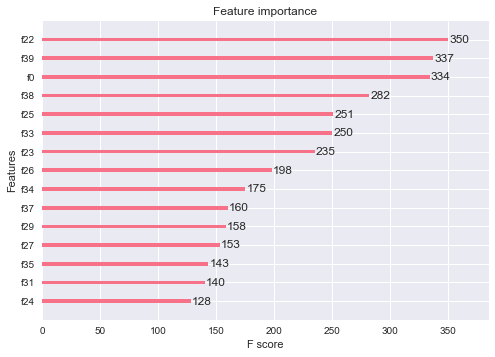

In [34]:
xgb.plot_importance(clf,max_num_features=15)

Xgboost pointwise

In [35]:
t_1 = time.time()

clf = xgb.XGBRegressor(learning_rate=0.1, max_depth = 6, n_estimators = 100, seed=2017)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

'model training time:',round((time.time()-t_1)/60,1) ,'minutes\n'

('model training time:', 0.1, 'minutes\n')

Adaboost pointwise

In [38]:
clf=AdaBoostRegressor(random_state=2017)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

'model training time:',round((time.time()-t_1)/60,1) ,'minutes\n'

('model training time:', 49.4, 'minutes\n')

In [21]:
t_1 = time.time()

clf = RandomForestRegressor(n_estimators=150, max_depth=15, random_state=2017)
#rf = RandomForestRegressor(n_estimators=50, max_depth=15, random_state=0)
#clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

'model training time:',round((time.time()-t_1)/60,1) ,'minutes\n'
#pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv',index=False)

('model training time:', 4.1, 'minutes\n')

## <font color='green'>Setup 6</font>: Evaluation

* Method 1

In [50]:
from evaluation import *

eval_lst=eval_construct(y_pred,y_test,test_group)
eval_lst_random=eval_construct_random(y_test,test_group)
mean_NDCG(eval_lst),mean_NDCG(eval_lst_random)

TypeError: unsupported operand type(s) for -: 'str' and 'int'

* Method 2

In [51]:
import pyltr
metric = pyltr.metrics.NDCG()
print 'Random ranking:', metric.calc_mean_random(test_query_label, y_test)
metric = pyltr.metrics.NDCG()
print 'Current model:', metric.calc_mean(test_query_label,y_test, y_pred)

Random ranking:

TypeError: can't multiply sequence by non-int of type 'float'

* another LambdaMart 

In [47]:
import pyltr

monitor = pyltr.models.monitors.ValidationMonitor(X_val, y_val, val_query_label, metric=metric, stop_after=250)

model = pyltr.models.LambdaMART(
    metric=metric,
    n_estimators=100,
    learning_rate=0.02,
    max_features=0.5,
    query_subsample=0.5,
    max_leaf_nodes=5,
    min_samples_leaf=64,
    verbose=1,
)

model.fit(X_train, y_train, train_query_label, monitor=monitor)
y_pred = model.predict(X_test)

 Iter  Train score  OOB Improve    Remaining                           Monitor Output 
    1       0.8539       0.0441        2.25m      C:      0.8503 B:      0.8503 S:  0
    2       0.8745       0.0204        2.06m      C:      0.8716 B:      0.8716 S:  0
    3       0.8866       0.0121        2.00m      C:      0.8827 B:      0.8827 S:  0
    4       0.8937       0.0077        1.96m      C:      0.8907 B:      0.8907 S:  0
    5       0.9002       0.0040        1.92m      C:      0.8947 B:      0.8947 S:  0
    6       0.9002       0.0014        1.90m      C:      0.8960 B:      0.8960 S:  0
    7       0.9047       0.0047        1.87m      C:      0.9012 B:      0.9012 S:  0
    8       0.9105       0.0046        1.84m      C:      0.9055 B:      0.9055 S:  0
    9       0.9118       0.0005        1.82m      C:      0.9056 B:      0.9056 S:  0
   10       0.9097       0.0011        1.81m      C:      0.9067 B:      0.9067 S:  0
   15       0.9128       0.0005        1.69m      C: 

In [53]:
pd.DataFrame({'id': id_test, 'relevance': y_pred}).to_csv('LambdaMART_pred.csv', index=False)